In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import tiktoken  # For OpenAI token counting

In [1]:
enc = tiktoken.encoding_for_model("gpt-4o")
print(len(enc.encode("""# NHIỆM VỤ: PHÂN TÍCH VÀ LỰA CHỌN CONTEXT TỐI ƯU

## BỐI CẢNH
Bạn là một chuyên gia phân tích thông tin y tế với chuyên môn sâu về:
- Y học lâm sàng và chẩn đoán bệnh
- Dược học và tác dụng của thuốc
- Thảo dược và y học tự nhiên  
- Sinh lý bệnh và cơ chế bệnh tật
- Điều trị và phòng ngừa bệnh

## NHIỆM VỤ CỤ THỂ
Phân tích danh sách context đã được sắp xếp theo độ liên quan (từ mô hình reranking) và lựa chọn context tối ưu nhất để trả lời câu hỏi y tế.

## NGUYÊN TẮC LỰA CHỌN
1. **Độ chính xác**: Context phải chứa thông tin chính xác, khoa học về chủ đề được hỏi
2. **Độ đầy đủ**: Context phải cung cấp đủ thông tin để trả lời hoàn chỉnh câu hỏi
3. **Độ tin cậy**: Ưu tiên context từ nguồn uy tín, có cơ sở khoa học
4. **Tính cụ thể**: Context phải cụ thể về cơ chế, liều lượng, cách sử dụng
5. **Tối ưu số lượng**: Ưu tiên chọn 1 context đầy đủ, chỉ lấy thêm nếu thực sự cần thiết

## THÔNG TIN CONTEXT
- Tất cả context được hiển thị đầy đủ (không bị cắt bớt)
- Field "content_length" cho biết độ dài của từng context
- Có thể phân tích toàn bộ nội dung để đưa ra quyết định chính xác

## DỮ LIỆU ĐẦU VÀO

**CÂU HỎI Y TẾ:**
{question}

**DANH SÁCH CONTEXT (theo thứ tự ưu tiên từ reranking model):**
{json.dumps(context_list, ensure_ascii=False, indent=2)}

## YÊU CẦU PHÂN TÍCH

### BƯỚC 1: Đánh giá từng context
- Xác định mức độ liên quan trực tiếp đến câu hỏi (0-10)
- Đánh giá độ đầy đủ thông tin (có đủ để trả lời không?)
- Kiểm tra tính chính xác và cơ sở khoa học
- Xác định điểm mạnh và điểm yếu của mỗi context

### BƯỚC 2: Lựa chọn context tối ưu
- Chọn context có điểm tổng hợp cao nhất (không nhất thiết phải top 1)
- Quyết định có cần kết hợp thêm context khác không
- Ưu tiên giải pháp tối thiểu (1 context nếu đủ)

### BƯỚC 3: Đưa ra quyết định cuối cùng

## FORMAT TRẦLỜI
Trả về ĐÚNG format JSON sau (không thêm text nào khác):

{{
    "selected_chunk_ids": ["chunk_X", "chunk_Y"],
    "reasoning": "Phân tích chi tiết: Context chunk_X được chọn vì [lý do cụ thể về độ chính xác, đầy đủ, tin cậy]. [Nếu chọn thêm context khác thì giải thích tại sao cần thiết]",
    "confidence": 0.XX,
    "analysis": {{
        "primary_context": "chunk_X",
        "supplementary_contexts": ["chunk_Y"] hoặc [],
        "coverage_assessment": "Đánh giá mức độ đủ thông tin để trả lời (đầy đủ/một phần/không đủ)"
    }}
}}

**LƯU Ý QUAN TRỌNG:**
- CHỈ trả về JSON, không có text giải thích thêm
- Confidence score phải phản ánh chính xác mức độ tin tưởng vào lựa chọn
- Reasoning phải cụ thể và có căn cứ khoa học""")))

NameError: name 'tiktoken' is not defined

In [5]:
def count_openai_tokens(text, model="gpt-4o"):
    """Count tokens using OpenAI's tiktoken library"""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

In [7]:
def analyze_token_content(file_path):
    """Analyze token counts from BGE-M3 and OpenAI for Q&A content"""
    
    # Initialize collectors
    bge_token_counts = []
    openai_question_tokens = []
    openai_answer_tokens = []
    openai_content_tokens = []
    questions = []
    answers = []
    
    print("Analyzing token counts (BGE-M3 and OpenAI)...")
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line_num, line in enumerate(file, 1):
                if line.strip():
                    try:
                        data = json.loads(line)
                        
                        # Extract BGE-M3 token count
                        bge_token_count = data.get('token_count', 0)
                        bge_token_counts.append(bge_token_count)
                        
                        # Get content for OpenAI tokenization
                        content = data.get('content', '')
                        if content:
                            openai_content_tokens.append(count_openai_tokens(content))
                        
                        # Extract Q&A from metadata
                        metadata = data.get('metadata', {})
                        question = metadata.get('question', '')
                        answer = metadata.get('answer', '')
                        
                        if question:
                            questions.append(question)
                            openai_question_tokens.append(count_openai_tokens(question))
                        
                        if answer:
                            answers.append(answer)
                            openai_answer_tokens.append(count_openai_tokens(answer))
                        
                        # Progress indicator
                        if line_num % 1000 == 0:
                            print(f"Processed {line_num} lines...")
                            
                    except json.JSONDecodeError as e:
                        print(f"Error parsing line {line_num}: {e}")
                        continue
                        
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    
    total_records = len(bge_token_counts)
    print(f"\nAnalysis complete! Processed {total_records} records.")
    
    return {
        'bge_token_counts': bge_token_counts,
        'openai_content_tokens': openai_content_tokens,
        'openai_question_tokens': openai_question_tokens,
        'openai_answer_tokens': openai_answer_tokens,
        'questions': questions,
        'answers': answers,
        'total_records': total_records
    }

In [8]:
file_path = "datasets/chunks/context_corpus_enhanced.jsonl"
data = analyze_token_content(file_path)

Analyzing token counts (BGE-M3 and OpenAI)...
Processed 1000 lines...
Processed 2000 lines...
Processed 3000 lines...
Processed 4000 lines...
Processed 5000 lines...
Processed 6000 lines...
Processed 7000 lines...
Processed 8000 lines...
Processed 9000 lines...
Processed 10000 lines...
Processed 11000 lines...
Processed 12000 lines...
Processed 13000 lines...
Processed 14000 lines...
Processed 15000 lines...
Processed 16000 lines...
Processed 17000 lines...

Analysis complete! Processed 17941 records.


In [9]:
print("=" * 70)
print("TOKEN COUNT ANALYSIS (BGE-M3 vs OpenAI)")
print("=" * 70)

print(f"\n📊 DATASET OVERVIEW:")
print(f"Total records: {data['total_records']:,}")
print(f"Records with questions: {len(data['questions']):,}")
print(f"Records with answers: {len(data['answers']):,}")

# BGE-M3 token count statistics
bge_tokens = data['bge_token_counts']
print(f"\n🎯 BGE-M3 TOKEN COUNT STATISTICS:")
print(f"  Mean: {np.mean(bge_tokens):.2f}")
print(f"  Median: {np.median(bge_tokens):.2f}")
print(f"  Min: {min(bge_tokens)}")
print(f"  Max: {max(bge_tokens)}")
print(f"  Std Dev: {np.std(bge_tokens):.2f}")
print(f"  25th percentile: {np.percentile(bge_tokens, 25):.2f}")
print(f"  75th percentile: {np.percentile(bge_tokens, 75):.2f}")
print(f"  Total tokens: {sum(bge_tokens):,}")

# OpenAI content token count statistics
openai_content_tokens = data['openai_content_tokens']
print(f"\n🤖 OPENAI CONTENT TOKEN COUNT STATISTICS:")
print(f"  Mean: {np.mean(openai_content_tokens):.2f}")
print(f"  Median: {np.median(openai_content_tokens):.2f}")
print(f"  Min: {min(openai_content_tokens)}")
print(f"  Max: {max(openai_content_tokens)}")
print(f"  Std Dev: {np.std(openai_content_tokens):.2f}")
print(f"  25th percentile: {np.percentile(openai_content_tokens, 25):.2f}")
print(f"  75th percentile: {np.percentile(openai_content_tokens, 75):.2f}")
print(f"  Total tokens: {sum(openai_content_tokens):,}")

TOKEN COUNT ANALYSIS (BGE-M3 vs OpenAI)

📊 DATASET OVERVIEW:
Total records: 17,941
Records with questions: 17,941
Records with answers: 17,941

🎯 BGE-M3 TOKEN COUNT STATISTICS:
  Mean: 134.49
  Median: 112.00
  Min: 7
  Max: 1524
  Std Dev: 94.55
  25th percentile: 68.00
  75th percentile: 177.00
  Total tokens: 2,412,958

🤖 OPENAI CONTENT TOKEN COUNT STATISTICS:
  Mean: 180.33
  Median: 152.00
  Min: 11
  Max: 1667
  Std Dev: 120.13
  25th percentile: 92.00
  75th percentile: 238.00
  Total tokens: 3,235,217


In [10]:
# OpenAI Question token statistics
if data['openai_question_tokens']:
    q_tokens = data['openai_question_tokens']
    print(f"\n❓ OPENAI QUESTION TOKEN STATISTICS:")
    print(f"  Mean: {np.mean(q_tokens):.2f} tokens")
    print(f"  Median: {np.median(q_tokens):.2f} tokens")
    print(f"  Min: {min(q_tokens)} tokens")
    print(f"  Max: {max(q_tokens)} tokens")
    print(f"  Std Dev: {np.std(q_tokens):.2f}")

# OpenAI Answer token statistics
if data['openai_answer_tokens']:
    a_tokens = data['openai_answer_tokens']
    print(f"\n✅ OPENAI ANSWER TOKEN STATISTICS:")
    print(f"  Mean: {np.mean(a_tokens):.2f} tokens")
    print(f"  Median: {np.median(a_tokens):.2f} tokens")
    print(f"  Min: {min(a_tokens)} tokens")
    print(f"  Max: {max(a_tokens)} tokens")
    print(f"  Std Dev: {np.std(a_tokens):.2f}")


❓ OPENAI QUESTION TOKEN STATISTICS:
  Mean: 18.39 tokens
  Median: 17.00 tokens
  Min: 5 tokens
  Max: 117 tokens
  Std Dev: 6.51

✅ OPENAI ANSWER TOKEN STATISTICS:
  Mean: 34.22 tokens
  Median: 30.00 tokens
  Min: 2 tokens
  Max: 258 tokens
  Std Dev: 20.26


In [7]:
print(f"\n📈 BGE-M3 TOKEN COUNT DISTRIBUTION:")
ranges = [(0, 25), (26, 50), (51, 100), (101, 200), (201, 500), (501, float('inf'))]
for start, end in ranges:
    if end == float('inf'):
        count = sum(1 for x in bge_tokens if x > start)
        print(f"  {start}+ tokens: {count:,} ({count/len(bge_tokens)*100:.1f}%)")
    else:
        count = sum(1 for x in bge_tokens if start <= x <= end)
        print(f"  {start}-{end} tokens: {count:,} ({count/len(bge_tokens)*100:.1f}%)")

print(f"\n📈 OPENAI CONTENT TOKEN COUNT DISTRIBUTION:")
for start, end in ranges:
    if end == float('inf'):
        count = sum(1 for x in openai_content_tokens if x > start)
        print(f"  {start}+ tokens: {count:,} ({count/len(openai_content_tokens)*100:.1f}%)")
    else:
        count = sum(1 for x in openai_content_tokens if start <= x <= end)
        print(f"  {start}-{end} tokens: {count:,} ({count/len(openai_content_tokens)*100:.1f}%)")


📈 BGE-M3 TOKEN COUNT DISTRIBUTION:
  0-25 tokens: 709 (4.0%)
  26-50 tokens: 2,135 (11.9%)
  51-100 tokens: 5,063 (28.2%)
  101-200 tokens: 6,221 (34.7%)
  201-500 tokens: 3,644 (20.3%)
  501+ tokens: 168 (0.9%)

📈 OPENAI CONTENT TOKEN COUNT DISTRIBUTION:
  0-25 tokens: 179 (1.0%)
  26-50 tokens: 809 (4.5%)
  51-100 tokens: 2,599 (14.5%)
  101-200 tokens: 5,318 (29.6%)
  201-500 tokens: 7,339 (40.9%)
  501+ tokens: 1,682 (9.4%)


In [8]:
# Compare BGE-M3 vs OpenAI tokenization
print(f"\n🔄 BGE-M3 vs OPENAI TOKEN COMPARISON:")
if len(data['bge_token_counts']) == len(data['openai_content_tokens']):
    ratio = np.array(data['bge_token_counts']) / np.array(data['openai_content_tokens'])
    print(f"  Mean BGE-M3/OpenAI ratio: {np.mean(ratio):.2f}")
    print(f"  Median BGE-M3/OpenAI ratio: {np.median(ratio):.2f}")
    print(f"  BGE-M3 typically produces {np.mean(ratio):.1f}x tokens compared to OpenAI")


🔄 BGE-M3 vs OPENAI TOKEN COMPARISON:
  Mean BGE-M3/OpenAI ratio: 0.57
  Median BGE-M3/OpenAI ratio: 0.56
  BGE-M3 typically produces 0.6x tokens compared to OpenAI


In [9]:
print(f"\n📝 SAMPLE QUESTIONS & ANSWERS WITH TOKEN COUNTS:")
print("-" * 60)

# Show 5 sample Q&A pairs
sample_size = min(5, len(data['questions']))
indices = np.random.choice(len(data['questions']), sample_size, replace=False)

for i, idx in enumerate(indices, 1):
    question = data['questions'][idx]
    answer = data['answers'][idx] if idx < len(data['answers']) else "N/A"
    q_tokens = data['openai_question_tokens'][idx] if idx < len(data['openai_question_tokens']) else 0
    a_tokens = data['openai_answer_tokens'][idx] if idx < len(data['openai_answer_tokens']) else 0
    
    print(f"\nSample {i}:")
    print(f"Q: {question}")
    print(f"A: {answer}")
    print(f"Question tokens (OpenAI): {q_tokens}")
    print(f"Answer tokens (OpenAI): {a_tokens}")
    print(f"Total Q&A tokens: {q_tokens + a_tokens}")
    print("-" * 40)


📝 SAMPLE QUESTIONS & ANSWERS WITH TOKEN COUNTS:
------------------------------------------------------------

Sample 1:
Q: Thuốc Aspegic được dùng trong những trường hợp nào?
A: Thuốc Aspegic được dùng trong các trường hợp người bệnh có vấn đề về sức khỏe như cảm lạnh, sốt, đau đầu, chóng mặt, cơn đau do bệnh về xương khớp cấp và mãn tính gây ra.
Question tokens (OpenAI): 22
Answer tokens (OpenAI): 86
Total Q&A tokens: 108
----------------------------------------

Sample 2:
Q: Liều lượng và cách dùng cây đinh lăng để điều trị mẩn ngứa do dị ứng như thế nào?
A: Để điều trị mẩn ngứa do dị ứng, dùng 80g lá cây đinh lăng đã sao vàng, sắc uống. Dùng trong 2 đến 3 tháng.
Question tokens (OpenAI): 42
Answer tokens (OpenAI): 57
Total Q&A tokens: 99
----------------------------------------

Sample 3:
Q: Nước Đại bi có tác dụng lợi tiểu tương tự với những loại thuốc lợi tiểu nào?
A: Nước Đại bi có tác dụng lợi tiểu tương tự như cà phê và chè.
Question tokens (OpenAI): 42
Answer tokens (OpenAI):

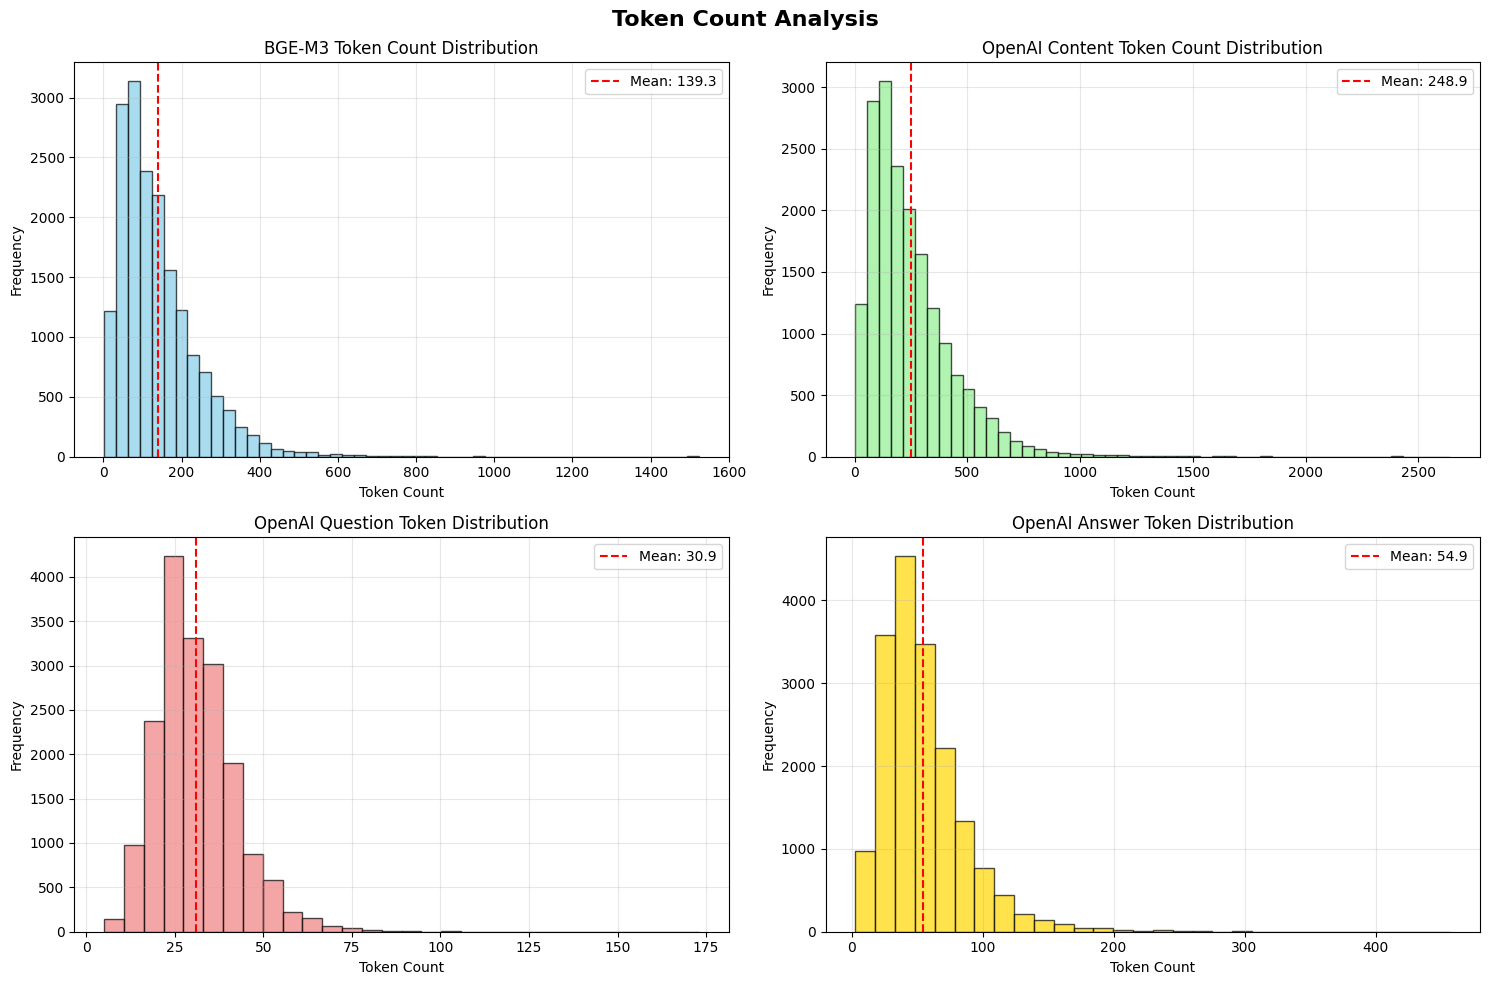

In [10]:
plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Token Count Analysis', fontsize=16, fontweight='bold')

# 1. BGE-M3 token count distribution
axes[0, 0].hist(data['bge_token_counts'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0, 0].set_title('BGE-M3 Token Count Distribution')
axes[0, 0].set_xlabel('Token Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(np.mean(data['bge_token_counts']), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(data["bge_token_counts"]):.1f}')
axes[0, 0].legend()

# 2. OpenAI content token count distribution
axes[0, 1].hist(data['openai_content_tokens'], bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
axes[0, 1].set_title('OpenAI Content Token Count Distribution')
axes[0, 1].set_xlabel('Token Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(np.mean(data['openai_content_tokens']), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(data["openai_content_tokens"]):.1f}')
axes[0, 1].legend()

# 3. OpenAI question token distribution
axes[1, 0].hist(data['openai_question_tokens'], bins=30, alpha=0.7, edgecolor='black', color='lightcoral')
axes[1, 0].set_title('OpenAI Question Token Distribution')
axes[1, 0].set_xlabel('Token Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(np.mean(data['openai_question_tokens']), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(data["openai_question_tokens"]):.1f}')
axes[1, 0].legend()

# 4. OpenAI answer token distribution
axes[1, 1].hist(data['openai_answer_tokens'], bins=30, alpha=0.7, edgecolor='black', color='gold')
axes[1, 1].set_title('OpenAI Answer Token Distribution')
axes[1, 1].set_xlabel('Token Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(np.mean(data['openai_answer_tokens']), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(data["openai_answer_tokens"]):.1f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

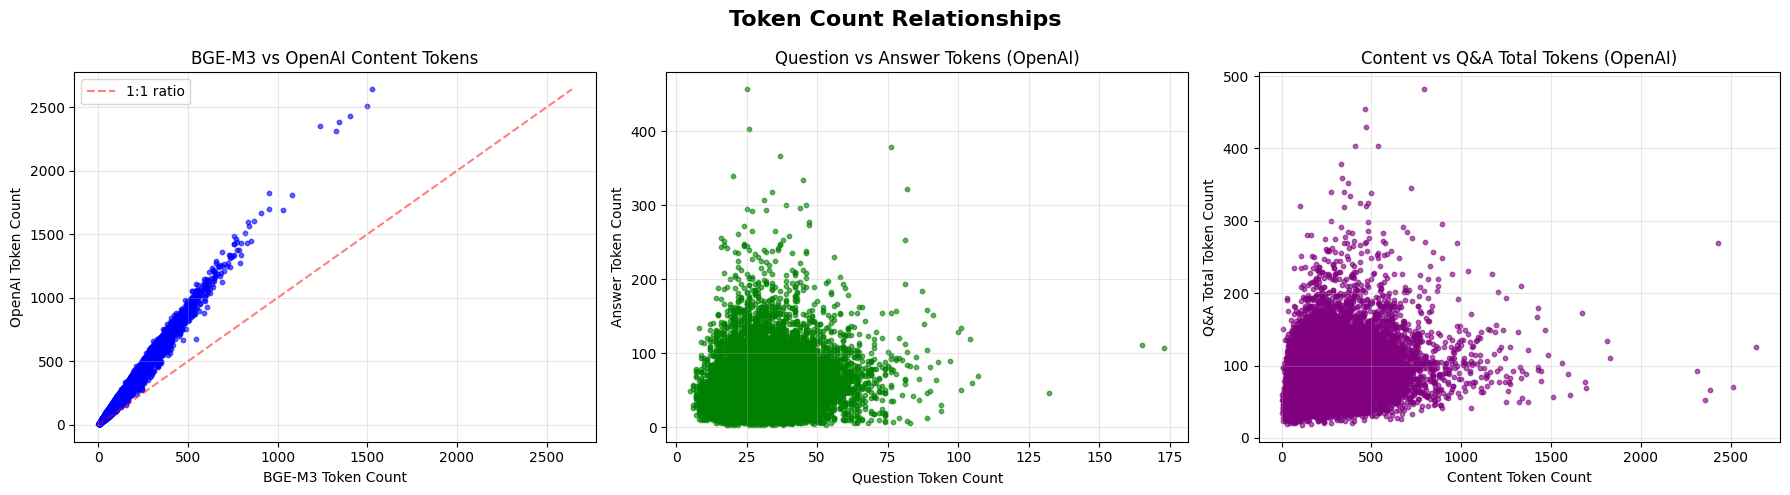

In [11]:
# Create figure with scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Token Count Relationships', fontsize=16, fontweight='bold')

# 1. BGE-M3 vs OpenAI content tokens
min_len = min(len(data['bge_token_counts']), len(data['openai_content_tokens']))
axes[0].scatter(data['bge_token_counts'][:min_len], data['openai_content_tokens'][:min_len], 
                alpha=0.6, s=10, color='blue')
axes[0].set_title('BGE-M3 vs OpenAI Content Tokens')
axes[0].set_xlabel('BGE-M3 Token Count')
axes[0].set_ylabel('OpenAI Token Count')
axes[0].grid(True, alpha=0.3)
# Add diagonal line for reference
max_val = max(max(data['bge_token_counts'][:min_len]), max(data['openai_content_tokens'][:min_len]))
axes[0].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='1:1 ratio')
axes[0].legend()

# 2. Question vs Answer tokens (OpenAI)
min_qa_len = min(len(data['openai_question_tokens']), len(data['openai_answer_tokens']))
axes[1].scatter(data['openai_question_tokens'][:min_qa_len], data['openai_answer_tokens'][:min_qa_len], 
                alpha=0.6, s=10, color='green')
axes[1].set_title('Question vs Answer Tokens (OpenAI)')
axes[1].set_xlabel('Question Token Count')
axes[1].set_ylabel('Answer Token Count')
axes[1].grid(True, alpha=0.3)

# 3. Content vs Q&A total tokens (OpenAI)
qa_total_tokens = [q + a for q, a in zip(data['openai_question_tokens'][:min_qa_len], 
                                         data['openai_answer_tokens'][:min_qa_len])]
axes[2].scatter(data['openai_content_tokens'][:min_qa_len], qa_total_tokens, 
                alpha=0.6, s=10, color='purple')
axes[2].set_title('Content vs Q&A Total Tokens (OpenAI)')
axes[2].set_xlabel('Content Token Count')
axes[2].set_ylabel('Q&A Total Token Count')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📊 TOKEN COUNT CORRELATION ANALYSIS:
                        bge_tokens  openai_content_tokens  \
bge_tokens                1.000000               0.992823   
openai_content_tokens     0.992823               1.000000   
openai_question_tokens    0.068838               0.084854   
openai_answer_tokens      0.250681               0.254096   

                        openai_question_tokens  openai_answer_tokens  
bge_tokens                            0.068838              0.250681  
openai_content_tokens                 0.084854              0.254096  
openai_question_tokens                1.000000              0.162293  
openai_answer_tokens                  0.162293              1.000000  


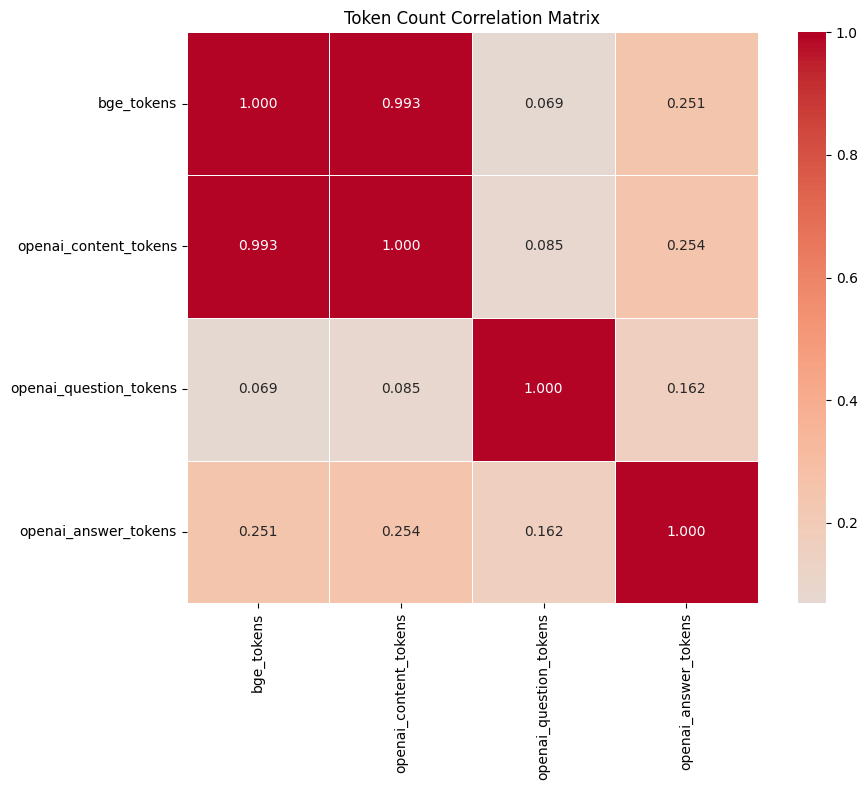

In [12]:
import pandas as pd

# Create DataFrame for correlation analysis
min_len = min(len(data['bge_token_counts']), len(data['openai_content_tokens']), 
              len(data['openai_question_tokens']), len(data['openai_answer_tokens']))

df_corr = pd.DataFrame({
    'bge_tokens': data['bge_token_counts'][:min_len],
    'openai_content_tokens': data['openai_content_tokens'][:min_len],
    'openai_question_tokens': data['openai_question_tokens'][:min_len],
    'openai_answer_tokens': data['openai_answer_tokens'][:min_len]
})

print("📊 TOKEN COUNT CORRELATION ANALYSIS:")
correlation_matrix = df_corr.corr()
print(correlation_matrix)

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, 
            fmt='.3f', linewidths=0.5)
plt.title('Token Count Correlation Matrix')
plt.tight_layout()
plt.show()